In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
CONFIGS = {
    'data_path': '../data/',
    'model_path': '../model/',
    'model_name': 'handling_missing_value',
    'model_type': 'cnn1d',
    
    'dtype': tf.float32,
    
    'valid_start_date_time': '2020-08-11 00',
    'test_start_date_time': '2020-08-18 00',
    
    'batch_size': 64,
    'learning_rate': 5e-5,
    'epochs': 100,
    'es_patience': 10,
    
    'window_size': 7*24,
    'shift': 1,
    'target_length': 3,
}

CONFIGS['tensorboard_log_path'] = f'../logs/tensorboard/{CONFIGS["model_name"]}'

In [3]:
train_origin = pd.read_csv(CONFIGS['data_path']+'train.csv', encoding='cp949')

In [4]:
data = deepcopy(train_origin)

data.columns = [
    'num', 'date_time', 'target', 'temp', 'wind',
    'humid', 'rain', 'sun', 'non_elec_eq', 'sunlight_eq'
]

data['num'] -= 1

missing_values = np.random.choice(data.shape[0], int(data.shape[0]*0.3), replace=False)
data.loc[missing_values, 'target'] = np.nan

CONFIGS['n_buildings'] = len(data['num'].unique())

In [5]:
def mk_time_data(data):
    
    new_data = data.copy()

    new_data['date_time'] = data['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H'))
    
    new_data['time_stamp'] = new_data['date_time'].apply(lambda x: x.timestamp())
    
    new_data['year'] = new_data['date_time'].apply(lambda x: x.year)
    new_data['month'] = new_data['date_time'].apply(lambda x: x.month)
    new_data['day'] = new_data['date_time'].apply(lambda x: x.day)
    
    new_data['hour'] = new_data['date_time'].apply(lambda x: x.hour)
    new_data['cos_hour'] = np.cos(2*np.pi*(new_data['hour']/24))
    new_data['sin_hour'] = np.sin(2*np.pi*(new_data['hour']/24))

    new_data['weekday'] = new_data['date_time'].apply(lambda x: x.weekday())
    new_data['cos_weekday'] = np.cos(2*np.pi*(new_data['weekday']/7))
    new_data['sin_weekday'] = np.sin(2*np.pi*(new_data['weekday']/7))
    
    new_data['is_holiday'] = 0
    new_data.loc[(new_data['weekday'] == 5) | (new_data['weekday'] == 6), 'is_holiday'] = 1
    new_data.loc[(new_data['month'] == 8) & (new_data['day'] == 17), 'is_holiday'] = 1
    
    return new_data

In [6]:
new_data = mk_time_data(data)

In [7]:
def mk_building_info(data, data_for_calc, CONFIGS):
        
    new_data = data.copy()
    new_data['range'] = 0
    new_data['mean'] = 0
    new_data['std'] = 0
    new_data['holiday_gap'] = 0
    new_data['day_gap'] = 0

    for num in range(CONFIGS['n_buildings']):
        building = data_for_calc.query(f'num == {num}')
        
        bt_range = building['target'].max()-building['target'].min()
        bt_mean = building['target'].mean()
        bt_std = building['target'].std()
        bt_holiday_gap = abs(building.query('is_holiday == 0')['target'].mean() - building.query('is_holiday == 1')['target'].mean())
        bt_day_gap = 0
        for d in range(building.shape[0]//24):
            tmp = building['target'][d*24:(d+1)*24]
            bt_day_gap += (tmp.max()-tmp.min())/(building.shape[0]//24)
            
        new_data.loc[new_data['num']==num, 'range'] = bt_range
        new_data.loc[new_data['num']==num, 'mean'] = bt_mean
        new_data.loc[new_data['num']==num, 'std'] = bt_std
        new_data.loc[new_data['num']==num, 'holiday_gap'] = bt_holiday_gap
        new_data.loc[new_data['num']==num, 'day_gap'] = bt_day_gap
        
    new_data['mean_to_inverse'] = new_data['mean']
    new_data['std_to_inverse'] = new_data['std']
        
    return new_data

In [8]:
new_data = mk_building_info(
    new_data,
    new_data[new_data['date_time']<CONFIGS['valid_start_date_time']],
    CONFIGS
)

In [9]:
def mk_mean_std_dict(data, scaling_by_building_cols):
    mean_std_dict = {}
    for num in range(60):
        building = data.query(f'num == {num}')
        mean_std_dict[num] = {
            col: {
                'mean': building[col].mean(),
                'std': building[col].std()
            } for col in scaling_by_building_cols
        }
    return mean_std_dict

In [10]:
scaling_by_building_cols = [
    'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp', 'target',
]
scaling_by_all_cols = ['range', 'mean', 'std', 'holiday_gap', 'day_gap']

mean_std_dict = mk_mean_std_dict(
    new_data[new_data['date_time'] < CONFIGS['valid_start_date_time']],
    scaling_by_building_cols
)
CONFIGS['mean_std_dict'] = mean_std_dict

In [11]:
def standard_scaling(data, scaling_by_building_cols, scaling_by_all_cols, mean_std_dict=None):
    if not mean_std_dict:
        mean_std_dict = mk_mean_std_dict(data, scaling_by_building_cols)
        
    new_data = data.copy()
    for num in range(60):
        for col in scaling_by_building_cols:
            new_data.loc[new_data['num']==num, col] -= mean_std_dict[num][col]['mean']
            new_data.loc[new_data['num']==num, col] /= mean_std_dict[num][col]['std']
    
    for col in scaling_by_all_cols:
        m = new_data.loc[:, col].mean()
        s = new_data.loc[:, col].std()
        new_data.loc[:, col] -= m
        new_data.loc[:, col] /= s
    
    return new_data

In [12]:
new_data = standard_scaling(new_data, scaling_by_building_cols, scaling_by_all_cols, mean_std_dict)

In [13]:
def visualize(data):

    eda_df = data[(data['date_time']<CONFIGS['valid_start_date_time'])]

    weekday_mean = eda_df.groupby(
        ['num', 'weekday'], as_index=False)['target'].mean().\
        pivot('num', 'weekday', 'target')

    hour_mean = eda_df.groupby(
        ['num', 'hour'], as_index=False)['target'].mean().\
        pivot('num', 'hour', 'target')

    day_mean = eda_df.groupby(
        ['num', 'day'], as_index=False)[['target']].mean().\
        pivot('num', 'day', 'target')


    fig = plt.figure(figsize = (20,4))
    for i in range(weekday_mean.shape[0]):
        plt.plot(weekday_mean.iloc[i, :], alpha = 0.5, linewidth = 0.5)
    plt.plot(weekday_mean.mean(axis=0), color='b', alpha = 0.7, linewidth=2)
    plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.title('Weekday mean')

    fig = plt.figure(figsize = (20,4))
    for i in range(hour_mean.shape[0]):
        plt.plot(hour_mean.iloc[i, :], alpha = 0.5, linewidth = 0.5)
    plt.plot(hour_mean.mean(axis=0), color='b', alpha = 0.7, linewidth=2)
    plt.xticks(range(24))
    plt.title('Hour mean')

    fig = plt.figure(figsize = (20,4))
    for i in range(day_mean.shape[0]):
        plt.plot(day_mean.iloc[i, :], alpha = 0.5, linewidth = 0.5)
    plt.plot(day_mean.mean(axis=0), color='b', alpha = 0.7, linewidth=2)
    plt.xticks(range(1, 32))
    plt.title('Day mean')

    plt.show()

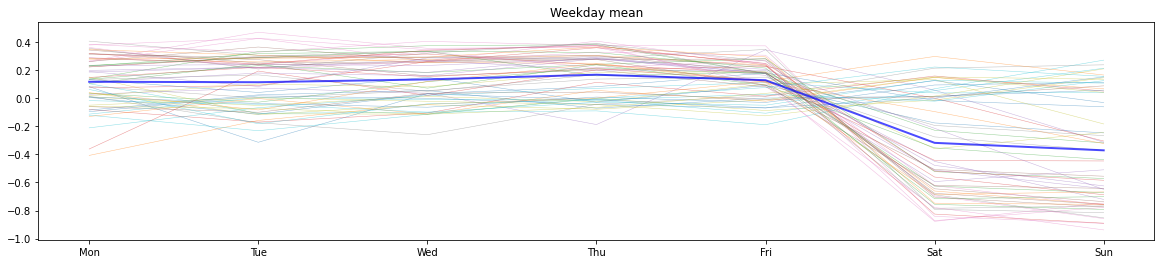

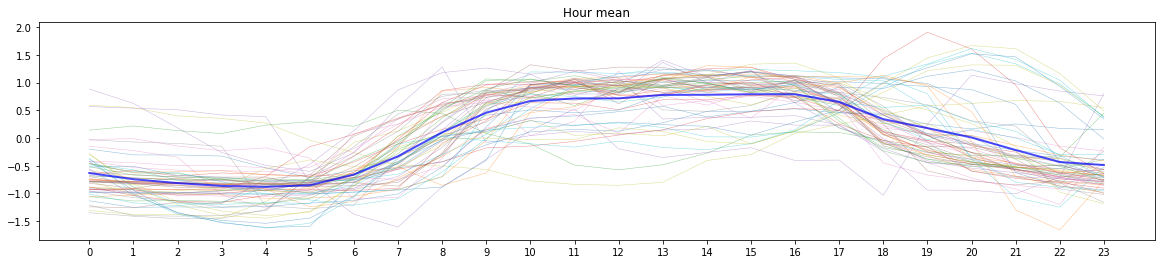

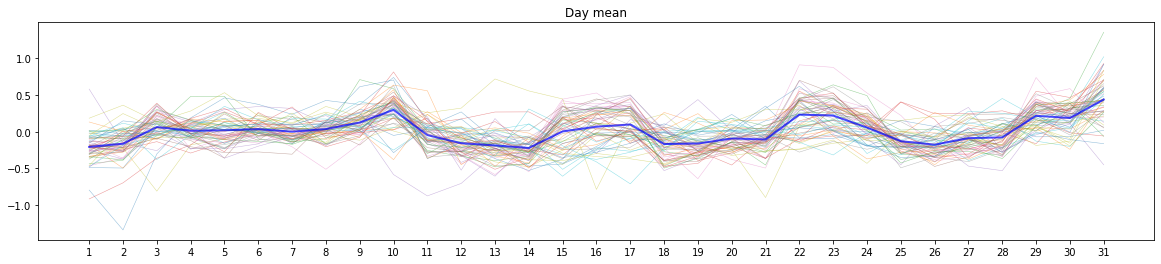

In [14]:
visualize(new_data)

In [15]:
def visualize_na_rate(data):
    eda_df = data.copy()

    eda_df['is_holiday'] = eda_df['is_holiday'].astype('category')
    cols = ['num', 'day', 'hour', 'weekday', 'is_holiday']

    fig = plt.figure(figsize = (len(cols)*5.7, 1*5))

    eda_df['is_na'] = eda_df['target'].isna().apply(int)
    for idx, col in enumerate(cols):
        tmp = eda_df.groupby([col], as_index=False)['is_na'].mean()
        plt.subplot(1, len(cols), idx+1)
        plt.bar(tmp[col], tmp['is_na'])
        plt.title(col)

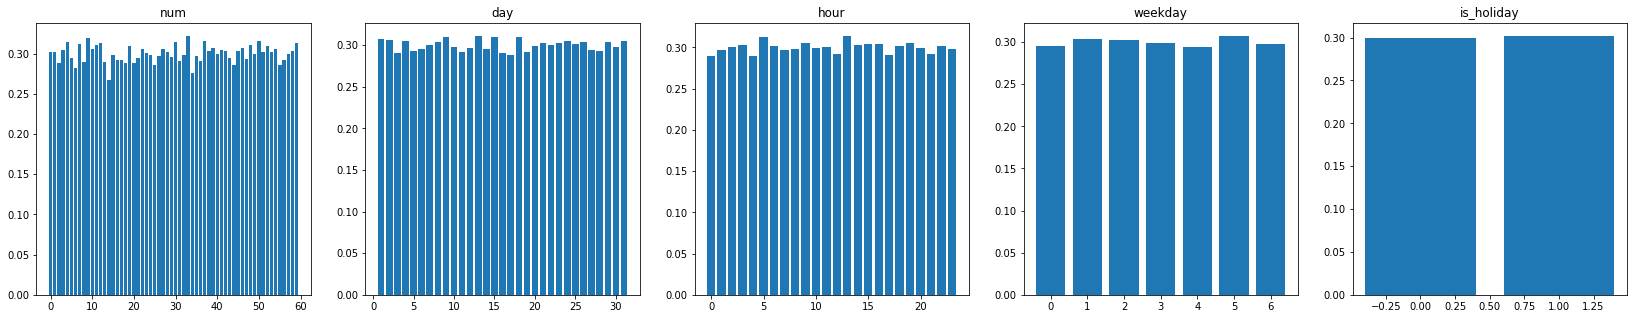

In [16]:
visualize_na_rate(new_data)

In [17]:
def fill_missing_value(data):
    new_data = data.copy()
    new_data['is_true'] = new_data['target'].notna().apply(int)
    for i in range(60):
        building = new_data[new_data['num'] == i]
        new_data.loc[new_data['num'] == i, 'target'] = building['target'].interpolate()
        fill = new_data.loc[(new_data['num'] == i)&(new_data['target'].notna()), 'target'].tolist()[0]
        new_data.loc[(new_data['num'] == i)&(new_data['target'].isna()), 'target'] = fill
    return new_data

In [18]:
new_data = fill_missing_value(new_data)

In [19]:
building_num_cols = ['num']
building_info_cols = [
    'range', 'mean', 'std', 'holiday_gap', 'day_gap',
    'non_elec_eq', 'sunlight_eq',
]
target_time_info_cols = [
    'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp',
    'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
    'is_holiday',
]
time_series_cols = [
    'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp',
    'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
    'is_holiday', 'is_true', 'target',
]
to_inverse_cols = ['mean_to_inverse', 'std_to_inverse']
is_true_cols = ['is_true']
target_cols = ['target']
input_cols = list(set(
    building_num_cols + building_info_cols + target_time_info_cols +
    time_series_cols + target_cols + to_inverse_cols + is_true_cols
))


CONFIGS['building_num_cols'] = building_num_cols
CONFIGS['building_info_cols'] = building_info_cols
CONFIGS['target_time_info_cols'] = target_time_info_cols
CONFIGS['time_series_cols'] = time_series_cols
CONFIGS['to_inverse_cols'] = to_inverse_cols
CONFIGS['is_true_cols'] = is_true_cols
CONFIGS['input_cols'] = input_cols
CONFIGS['target_cols'] = target_cols

In [20]:
def crop(data, crop_type, CONFIGS):
    building_length = tf.shape(data)[0]
    if crop_type == 'one_row':
        h = CONFIGS['target_length']//2
        croped = data[CONFIGS['window_size']+h:building_length-CONFIGS['target_length']+1+h]
    elif crop_type == 'time_series_input':
        croped = data[:-CONFIGS['target_length']]
    elif crop_type == 'target':
        croped = data[CONFIGS['window_size']:]
    return croped


def mk_window(data, size, shift):
    ds = Dataset.from_tensor_slices(data)
    ds = ds.window(
        size=size, shift=shift, drop_remainder=True
    ).flat_map(lambda x: x).batch(size)
    return ds


def mk_time_series(data, building_length, crop_type, CONFIGS, dtype=None):
    if not dtype:
        dtype = CONFIGS['dtype']

    ds = Dataset.from_tensor_slices(data).batch(building_length)
    if crop_type == 'one_row':
        ds = ds.map(lambda x: crop(x, crop_type, CONFIGS))
        ds = ds.flat_map(lambda x: Dataset.from_tensor_slices(x))
    elif crop_type == 'time_series_input':
        ds = ds.map(lambda x: crop(x, crop_type, CONFIGS))
        ds = ds.flat_map(
            lambda x: mk_window(x, CONFIGS['window_size'], CONFIGS['shift']))
    elif crop_type == 'target':
        ds = ds.map(lambda x: crop(x, crop_type, CONFIGS))
        ds = ds.flat_map(
            lambda x: mk_window(x, CONFIGS['target_length'], CONFIGS['shift']))
    ds.map(lambda x: tf.cast(x, dtype))

    return ds


def mk_dataset(data, CONFIGS, shuffle=False):

    data = data[CONFIGS['input_cols']]
    building_length = data.shape[0]//60

    building_num = data[CONFIGS['building_num_cols']]
    building_info = data[CONFIGS['building_info_cols']]
    target_time_info = data[CONFIGS['target_time_info_cols']]
    time_series = data[CONFIGS['time_series_cols']]
    to_inverse = data[CONFIGS['to_inverse_cols']]
    is_true = data[CONFIGS['is_true_cols']]
    target = data[CONFIGS['target_cols']]

    building_num_ds = mk_time_series(building_num, building_length, 'one_row', CONFIGS, tf.int16)
    building_info_ds = mk_time_series(building_info, building_length, 'one_row', CONFIGS)
    target_time_info_ds = mk_time_series(target_time_info, building_length, 'one_row', CONFIGS)
    time_series_ds = mk_time_series(time_series, building_length, 'time_series_input', CONFIGS)
    to_inverse_ds = mk_time_series(to_inverse, building_length, 'target', CONFIGS)
    is_true_ds = mk_time_series(is_true, building_length, 'target', CONFIGS)
    target_ds = mk_time_series(target, building_length, 'target', CONFIGS)
    
    # zip
    ds = Dataset.zip((
        (
            building_num_ds,
            building_info_ds,
            target_time_info_ds,
            time_series_ds,
            to_inverse_ds,
            is_true_ds
        ),
        target_ds
    ))
    if shuffle:
        ds = ds.shuffle(512)
    ds = ds.batch(CONFIGS['batch_size']).cache().prefetch(2)
    
    return ds

In [21]:
str_to_dt = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H')
hour_to_td = lambda x: datetime.timedelta(hours=x)

train = new_data.loc[
    new_data['date_time'] < \
        str_to_dt(CONFIGS['valid_start_date_time']),
    :
]
valid = new_data.loc[
    (new_data['date_time'] >= \
        str_to_dt(CONFIGS['valid_start_date_time'])-hour_to_td(CONFIGS['window_size']))&\
    (new_data['date_time'] < \
         str_to_dt(CONFIGS['test_start_date_time'])),
    :
]
test = new_data.loc[
    new_data['date_time'] >= \
        str_to_dt(CONFIGS['test_start_date_time'])-hour_to_td(CONFIGS['window_size']),
    :
]

train_ds = mk_dataset(train, CONFIGS, shuffle=True)
valid_ds = mk_dataset(valid, CONFIGS)
test_ds = mk_dataset(test, CONFIGS)

2022-02-10 06:15:46.604162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 06:15:46.607474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 06:15:46.607848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 06:15:46.608834: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
class CustomMSE(Loss):
    
    def __init__(self, target_max, name="custom_mse"):
        super(CustomMSE, self).__init__(name=name)
        self.target_max = target_max

    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        y_pred, mean, std, is_true = \
            y_pred[..., 0], y_pred[..., 1], y_pred[..., 2], y_pred[..., 3]

        y_true_inversed = y_true*std+mean
        y_pred_inversed = y_pred*std+mean
        
        y_true_inversed_scaled = y_true_inversed/self.target_max
        y_pred_inversed_scaled = y_pred_inversed/self.target_max

        mse = tf.reduce_mean((y_true_inversed_scaled-y_pred_inversed_scaled)**2)
        return mse

In [23]:
class InversedRMSE(Metric):
    
    def __init__(self, CONFIGS, name="inversed_rmse", **kwargs):
        super(InversedRMSE, self).__init__(name=name, **kwargs)
        self.inversed_mse = self.add_weight(name='inversed_mse', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        self.CONFIGS = CONFIGS

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        y_pred, mean, std, is_true = \
            y_pred[..., 0], y_pred[..., 1], y_pred[..., 2], y_pred[..., 3]

        y_true_inversed = y_true*std+mean
        y_pred_inversed = y_pred*std+mean

        error = tf.reduce_sum(tf.math.squared_difference(y_true_inversed, y_pred_inversed))
        
        self.inversed_mse.assign_add(error)
        self.count.assign_add(tf.cast(tf.size(y_true), CONFIGS['dtype']))

    def result(self):
        return tf.sqrt(tf.math.divide_no_nan(self.inversed_mse, self.count))

In [24]:
class BuildingNum(Layer):

    def __init__(self, CONFIGS, name='building_num_layer', **kwargs):
        super(BuildingNum, self).__init__(name=name, **kwargs)
        self.building_num_emb = Embedding(
            input_dim=CONFIGS['n_buildings'],
            output_dim=CONFIGS['embedding_dim']
        )
        self.bn_outputs = Reshape(target_shape=(CONFIGS['embedding_dim'],))
        
    def get_config(self):
        config = super(BuildingNum, self).get_config().copy()
        config.update({
            'building_num_emb': self.building_num_emb,
            'bn_outputs': self.bn_outputs,
        })
        return config
        
    def call(self, inputs):
        x = self.building_num_emb(inputs)
        outputs = self.bn_outputs(x)
        return outputs
    

class BuildingInfo(Layer):
    
    def __init__(self, CONFIGS, name='building_info_layer', **kwargs):
        super(BuildingInfo, self).__init__(name=name, **kwargs)
        self.bi_dense_0 = Dense(16, activation='relu')
        self.dropout_0 = Dropout(0.3)
        self.bi_outputs = Dense(32, activation='relu')
        
    def get_config(self):
        config = super(BuildingInfo, self).get_config().copy()
        config.update({
            'bi_dense_0': self.bi_dense_0,
            'dropout_0': self.dropout_0,
            'bi_outputs': self.bi_outputs,
        })
        return config
        
    def call(self, inputs):
        x = self.bi_dense_0(inputs)
        x = self.dropout_0(x)
        outputs = self.bi_outputs(x)
        return outputs
    

class TargetTimeInfo(Layer):
    
    def __init__(self, CONFIGS, name='target_time_info_layer', **kwargs):
        super(TargetTimeInfo, self).__init__(name=name, **kwargs)
        self.tti_dense_0 = Dense(16, activation='relu')
        self.dropout_0 = Dropout(0.3)
        self.tti_outputs = Dense(32, activation='relu')
        
    def get_config(self):
        config = super(TargetTimeInfo, self).get_config().copy()
        config.update({
            'tti_dense_0': self.tti_dense_0,
            'dropout_0': self.dropout_0,
            'tti_outputs': self.tti_outputs,
        })
        return config
        
    def call(self, inputs):
        x = self.tti_dense_0(inputs)
        x = self.dropout_0(x)
        outputs = self.tti_outputs(x)
        return outputs
    

class TimeSeries(Layer):
    
    def __init__(self, CONFIGS, name='time_series_layer', **kwargs):
        super(TimeSeries, self).__init__(name=name, **kwargs)
        
        if CONFIGS['model_type'] == 'flatten':
            pass
        elif CONFIGS['model_type'] == 'cnn1d':
            self.conv1d_0 = Conv1D(16, 3, 2, activation='relu')
            self.pool1d_0 = MaxPool1D(2)
            self.conv1d_1 = Conv1D(32, 3, 2, activation='relu')
            self.pool1d_1 = MaxPool1D(2)
        elif CONFIGS['model_type'] == 'cnn2d':
            self.conv2d_reshape = Reshape(target_shape=(
                CONFIGS['window_size'], len(CONFIGS['time_series_cols']), 1
            ))
            self.conv2d_0 = Conv2D(8, (3, 1), strides=(2, 1), activation='relu')
            self.pool2d_0 = MaxPool2D((2, 1))
            self.conv2d_1 = Conv2D(16, (3, 1), strides=(2, 1), activation='relu')
            self.pool2d_1 = MaxPool2D((2, 1))
        elif CONFIGS['model_type'] == 'lstm':
            self.lstm_0 = LSTM(16, return_sequences=True, activation='relu')
            self.lstm_1 = LSTM(32, activation='relu')
        elif CONFIGS['model_type'] == 'bilstm':
            self.bilstm_0 = Bidirectional(LSTM(16, return_sequences=True, activation='relu'))
            self.bilstm_1 = Bidirectional(LSTM(32, activation='relu'))
        self.time_series_outputs = Flatten()
        
    def get_config(self):
        config = super(TimeSeries, self).get_config().copy()
        if CONFIGS['model_type'] == 'flatten':
            pass
        elif CONFIGS['model_type'] == 'cnn1d':
            config.update({
                'conv1d_0': self.conv1d_0,
                'pool1d_0': self.pool1d_0,
                'conv1d_1': self.conv1d_1,
                'pool1d_1': self.pool1d_1,
            })
        elif CONFIGS['model_type'] == 'cnn2d':
            config.update({
                'conv2d_reshape': self.conv2d_reshape,
                'conv2d_0': self.conv2d_0,
                'pool2d_0': self.pool2d_0,
                'conv2d_1': self.conv2d_1,
                'pool2d_1': self.pool2d_1,
            })
        elif CONFIGS['model_type'] == 'lstm':
            config.update({
                'lstm_0': self.lstm_0,
                'lstm_1': self.lstm_1,
            })
        elif CONFIGS['model_type'] == 'bilstm':
            config.update({
                'bilstm_0': self.bilstm_0,
                'bilstm_1': self.bilstm_1,
            })
        config.update({
            'time_series_outputs': self.time_series_outputs,
        })
        return config
        
    def call(self, inputs):
        if CONFIGS['model_type'] == 'flatten':
            x = inputs
        elif CONFIGS['model_type'] == 'cnn1d':
            x = self.conv1d_0(inputs)
            x = self.pool1d_0(x)
            x = self.conv1d_1(x)
            x = self.pool1d_1(x)
        elif CONFIGS['model_type'] == 'cnn2d':
            x = self.conv2d_reshape(x)
            x = self.conv2d_0(x)
            x = self.pool2d_0(x)
            x = self.conv2d_1(x)
            x = self.pool2d_1(x)
        elif CONFIGS['model_type'] == 'lstm':
            x = self.lstm_0(x)
            x = self.lstm_1(x)
        elif CONFIGS['model_type'] == 'bilstm':
            x = self.bilstm_0(x)
            x = self.bilstm_1(x)
        outputs = self.time_series_outputs(x)
        return outputs

In [25]:
def set_model(CONFIGS, model_name=None, print_summary=False):
    
    # building_num
    building_num_inputs = Input(batch_shape=(None, 1), name='building_num_inputs')
    bn_outputs = BuildingNum(CONFIGS)(building_num_inputs)
    
    # building_info
    building_info_inputs = Input(
        batch_shape=(None, len(CONFIGS['building_info_cols'])),
        name='building_info_inputs'
    )
    bi_outputs = BuildingInfo(CONFIGS)(building_info_inputs)
    
    # target_time_info
    target_time_info_inputs = Input(
        batch_shape=(None, len(CONFIGS['target_time_info_cols'])),
        name='target_time_info_inputs'
    )
    tti_outputs = TargetTimeInfo(CONFIGS)(target_time_info_inputs)
    
    # time_series
    time_series_inputs = Input(batch_shape=(
        None, CONFIGS['window_size'], len(CONFIGS['time_series_cols'])
    ), name='time_series_inputs')
    time_series_outputs = TimeSeries(CONFIGS)(time_series_inputs)
    
    concat = Concatenate(name='concat')([bn_outputs, bi_outputs, tti_outputs, time_series_outputs])
        
    dense_0 = Dense(64, activation='relu', name='dense_0')(concat)
    dropout_0 = Dropout(0.3, name='dropout_0')(dense_0)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dropout_0)
    dropout_1 = Dropout(0.3, name='dropout_0')(dense_1)
    dense_2 = Dense(CONFIGS['target_length'], name='dense_2')(dense_1)
    
    reshape_dense = Reshape(target_shape=(
        CONFIGS['target_length'], 1
    ), name='reshape_dense')(dense_2)
    
    # to_inverse & is_true
    to_inverse_inputs = Input(batch_shape=(
        None, CONFIGS['target_length'], len(CONFIGS['to_inverse_cols'])
    ), name='to_inverse_inputs')
    is_true_inputs = Input(batch_shape=(
        None, CONFIGS['target_length'], len(CONFIGS['is_true_cols'])
    ), name='is_true_inputs')
    outputs = Concatenate(axis=-1, name='concat_to_inverse')([
        reshape_dense, to_inverse_inputs, is_true_inputs
    ])
    
    if not model_name:
        model_name = CONFIGS['model_name']
    
    model = Model(
        inputs = [
            building_num_inputs,
            building_info_inputs,
            target_time_info_inputs,
            time_series_inputs,
            to_inverse_inputs,
            is_true_inputs,
        ],
        outputs = outputs,
        name = model_name
    )
    
    custom_mse = CustomMSE(CONFIGS['target_max'])
    inversed_rmse = InversedRMSE(CONFIGS)
    optimizer = Adam(learning_rate=CONFIGS['learning_rate'])
    model.compile(
        loss = custom_mse,
        optimizer = optimizer,
        metrics = [inversed_rmse],
    )
    
    if print_summary:
        model.summary()
    
    return model

In [26]:
CONFIGS['target_max'] = \
    data[data['date_time']<CONFIGS['valid_start_date_time']]['target'].max()
CONFIGS['embedding_dim'] = 10

model = set_model(CONFIGS, print_summary=True)

Model: "handling_missing_value"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 building_num_inputs (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 building_info_inputs (InputLay  [(None, 7)]         0           []                               
 er)                                                                                              
                                                                                                  
 target_time_info_inputs (Input  [(None, 11)]        0           []                               
 Layer)                                                                      

In [27]:
def train_model(model, train_ds, valid_ds, CONFIGS):
    
    early_stop = EarlyStopping(
        patience=CONFIGS['es_patience']
    )
    save_best_only = ModelCheckpoint(
        filepath = f'{CONFIGS["model_path"]}{CONFIGS["model_name"]}.h5',
        monitor = 'val_loss',
        save_best_only = True,
        save_weights_only = True
    )
    tensorboard_callback = TensorBoard(
        log_dir = CONFIGS['tensorboard_log_path']
    )
    
    history = model.fit(
        train_ds,
        batch_size = CONFIGS['batch_size'],
        epochs = CONFIGS['epochs'],
        validation_data = valid_ds,
        callbacks = [
            early_stop,
            save_best_only,
            tensorboard_callback,
        ]
    )
    
    return history

In [28]:
history = train_model(model, train_ds, valid_ds, CONFIGS)

Epoch 1/100


2022-02-10 06:15:50.145725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1439/1439 [==============================] - 19s 10ms/step - loss: 0.0020 - inversed_rmse: 745.6540 - val_loss: 0.0021 - val_inversed_rmse: 764.5430
Epoch 2/100
1439/1439 [==============================] - 6s 4ms/step - loss: 0.0013 - inversed_rmse: 598.6932 - val_loss: 0.0014 - val_inversed_rmse: 640.8262
Epoch 3/100
1439/1439 [==============================] - 6s 4ms/step - loss: 9.4010e-04 - inversed_rmse: 517.4146 - val_loss: 0.0012 - val_inversed_rmse: 579.6428
Epoch 4/100
1439/1439 [==============================] - 6s 4ms/step - loss: 7.8366e-04 - inversed_rmse: 472.4056 - val_loss: 0.0011 - val_inversed_rmse: 550.6628
Epoch 5/100
1439/1439 [==============================] - 6s 4ms/step - loss: 6.6986e-04 - inversed_rmse: 436.7603 - val_loss: 9.8885e-04 - val_inversed_rmse: 530.6594
Epoch 6/100
1439/1439 [==============================] - 6s 4ms/step - loss: 5.8781e-04 - inversed_rmse: 409.1374 - val_loss: 9.1983e-04 - val_inversed_rmse: 511.8045
Epoch 7/100
1439/1439 [=========

1439/1439 [==============================] - 6s 4ms/step - loss: 1.9231e-04 - inversed_rmse: 234.0213 - val_loss: 6.8514e-04 - val_inversed_rmse: 441.7123
Epoch 51/100
1439/1439 [==============================] - 6s 4ms/step - loss: 1.9087e-04 - inversed_rmse: 233.1416 - val_loss: 6.8399e-04 - val_inversed_rmse: 441.3405
Epoch 52/100
1439/1439 [==============================] - 6s 4ms/step - loss: 1.8826e-04 - inversed_rmse: 231.5390 - val_loss: 6.7739e-04 - val_inversed_rmse: 439.2074
Epoch 53/100
1439/1439 [==============================] - 6s 4ms/step - loss: 1.8706e-04 - inversed_rmse: 230.8026 - val_loss: 6.7657e-04 - val_inversed_rmse: 438.9408
Epoch 54/100
1439/1439 [==============================] - 6s 4ms/step - loss: 1.8636e-04 - inversed_rmse: 230.3708 - val_loss: 6.7921e-04 - val_inversed_rmse: 439.7965
Epoch 55/100
1439/1439 [==============================] - 6s 4ms/step - loss: 1.8499e-04 - inversed_rmse: 229.5204 - val_loss: 6.8344e-04 - val_inversed_rmse: 441.1635


In [29]:
best_model = set_model(CONFIGS, model_name='best_'+CONFIGS['model_name'])
best_model.load_weights(f'{CONFIGS["model_path"]}{CONFIGS["model_name"]}.h5')

In [30]:
train_loss, train_rmse = best_model.evaluate(train_ds, verbose=0)
valid_loss, valid_rmse = best_model.evaluate(valid_ds, verbose=0)
test_loss, test_rmse = best_model.evaluate(test_ds, verbose=0)

print(f'train_loss: {train_loss:.6f}\ttrain_rmse: {train_rmse:.6f}')
print(f'valid_loss: {valid_loss:.6f}\tvalid_rmse: {valid_rmse:.6f}')
print(f'test_loss: {test_loss:.6f}\ttest_rmse: {test_rmse:.6f}')

train_loss: 0.000177	train_rmse: 224.546661
valid_loss: 0.000667	valid_rmse: 435.688721
test_loss: 0.000498	test_rmse: 376.542938
